In [1]:
from pyNastran.bdf.bdf import BDF

# Create BDF object
ucrm9_bdf_input = BDF(debug=None)
# Create case control deck
ucrm9_bdf_input.create_subcases(0)
ucrm9_bdf_input.case_control_deck.subcases[0].add('ECHO', 'NONE', [], 'STRING-type')  # request no Bulk Data to be printed
ucrm9_bdf_input.case_control_deck.subcases[0].add_result_type('STRAIN', 'ALL', ['PLOT'])  # store strain data of all nodes in the op2 file
ucrm9_bdf_input.case_control_deck.subcases[0].add_result_type('STRESSES', 'ALL', ['PLOT'])  # store stress data of all nodes in the op2 file
ucrm9_bdf_input.case_control_deck.subcases[0].add_result_type('DISPLACEMENT', 'ALL', ['PLOT'])  # store displacement data of all nodes in the op2 file
ucrm9_bdf_input.case_control_deck.subcases[0].add_result_type('OLOAD', 'ALL', ['PLOT'])  # store form and type of applied load vector
constraint_set_id = 1
ucrm9_bdf_input.case_control_deck.subcases[0].add_integer_type('SPC', constraint_set_id)

subcase=0 already exists...skipping


In [2]:
ucrm9_bdf_input.add_param('AUTOSPC', ['NO'])  # singularities in the stiffness matrix will not be constrained
ucrm9_bdf_input.add_param('GRDPNT', [1])  # execute grid point weight generator using node with id 1 as reference point
ucrm9_bdf_input.add_param('K6ROT', [1e5])  # specifies the scaling factor of the penalty stiffness to be added to the normal rotation for CQUAD4 and CTRIA3 elements
ucrm9_bdf_input.add_param('COUPMASS', [-1])  # causes the generation of lumped mass matrices (which may include torsion inertia for beam elements, and some coupling if there are beam offsets) for the following elements: CBAR, CBEAM, CONROD, CQUAD4, CHEXA, CPENTA, CPYRAM, CQUAD8, CROD, CTETRA, CTRIA3, CTRlA6, CTRIAX6, CTUBE
ucrm9_bdf_input.add_param('MAXRATIO', [1e7])  # threshold for the ratios of terms on the diagonal of the stiffness matrix to the corresponding terms on the diagonal of the triangular factor above which the matrix will be considered to be nearly singular
ucrm9_bdf_input.add_param('POST', [1])  # store results in a op2 file
ucrm9_bdf_input.add_param('POST', [1.])  # the terms of the structural mass matrix are multiplied by the value of WTMASS when they are generated

PARAM       POST      1.

In [3]:
import os

ucrm9_bdf_input.add_include_file(os.path.join(os.pardir, os.pardir, 'resources', 'uCRM-9_wingbox_coarse.bdf'))
ucrm9_bdf_input.add_include_file(os.path.join(os.pardir, os.pardir, 'resources', 'uCRM-9_aero_forces_1.0g_coarse.bdf'))

In [4]:
from resources import pynastran_utils

force_set_id = 1
analysis_directory_name = '15_Nonlinear_Buckling_Analysis_of_uCRM-9'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)
input_name = 'uCRM9_linear_buckling'
sol_105_op2 = pynastran_utils.run_sol_105_buckling_analysis(bdf_object=ucrm9_bdf_input.__deepcopy__({}), static_load_set_id=force_set_id, analysis_directory_path=analysis_directory_path, input_name=input_name, run_flag=False)

Nastran job uCRM9_linear_buckling.bdf completed
Wall time: 17.0 s


CORD2R         1              0.      0.      0.     -1.      0.      0.
              0.      0.      1.

CORD2R         2              0.      0.      0.     -1.      0.      0.
              0.      0.      1.

CORD2R         3              0.      0.      0.     -1.      0.      0.
              0.      0.      1.

CORD2R         4              0.      0.      0.     -1.      0.      0.
              0.      0.      1.

CORD2R         5              0.      0.      0.     -1.      0.      0.
              0.      0.      1.

CORD2R         6              0.      0.      0.     -1.      0.      0.
              0.      0.      1.

CORD2R         7              0.      0.      0.     -1.      0.      0.
              0.      0.      1.

CORD2R         8              0.      0.      0.     -1.      0.      0.
              0.      0.      1.

CORD2R         9              0.      0.      0.     -1.      0.      0.
              0.      0.      1.

CORD2R        10              0.     

Buckling factor: 2.9


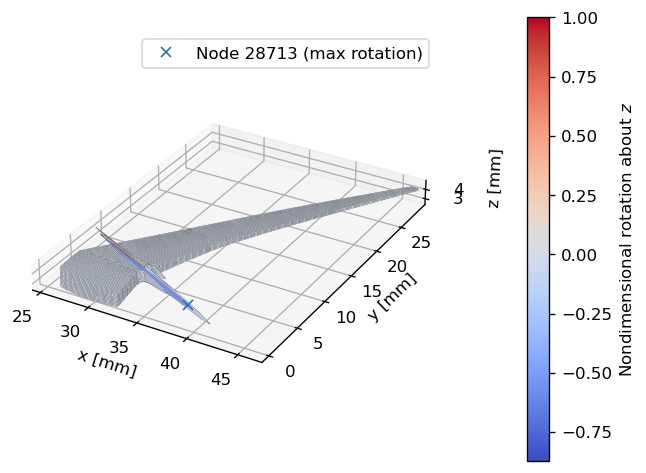

In [5]:
import matplotlib.pyplot as plt  # plotting libary
import numpy as np

# Find critical buckling factor and print it
eigenvalue_calculation_subcase_id = 2
sol_105_buckling_factor = sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].eigr
print(f'Buckling factor: {sol_105_buckling_factor:.1f}')

# Plot buckling mode
plt.rcParams['figure.dpi'] = 120 # set default dpi of figures
_, ax = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=eigenvalue_calculation_subcase_id, displacement_component='rz', colormap='coolwarm')
ax.locator_params(axis='z', nbins=2)  # set number of ticks of z-axis

# Plot max rotation node
max_rotation_index = np.argmax(sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].data[0, :, 5])
max_rotation_node_id = sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].node_gridtype[max_rotation_index, 0]
max_rotation_node_xyz = sol_105_op2.nodes[max_rotation_node_id].xyz + 200*sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].data[0, max_rotation_index, 0:3]
ax.plot(max_rotation_node_xyz[0], max_rotation_node_xyz[1], max_rotation_node_xyz[2], 'x', label=f'Node {max_rotation_node_id:d} (max rotation)', zorder=4)
ax.legend()

# Show plot
plt.show()

In [6]:
load_scale_factor = 2
load_set_id = force_set_id + 1  # define id of load set
ucrm9_bdf_input.add_load(sid=load_set_id, scale=1., scale_factors=[sol_105_buckling_factor*load_scale_factor], load_ids=[force_set_id])  # add LOAD card to define load set
pynastran_utils.create_static_load_subcase(bdf_object=ucrm9_bdf_input, subcase_id=1, load_set_id=load_set_id)  # create subcase with defined load set
pynastran_utils.set_up_arc_length_method(ucrm9_bdf_input)  # set up SOL 106 with arc-length method using default parameters

In [7]:
ucrm9_bdf_input.system_command_lines[0:0] = ['NASTRAN QRMETH=3']

In [8]:
from matplotlib.lines import Line2D  # class defining the characters for the marker styles
from pyNastran.op2.op2 import read_op2

tip_node_id = 11847
displacement_component_index = 2
markers = list(Line2D.markers.keys())[2:]  # list of marker characters

def compare_load_displacement_diagrams(bdf_input, filename, axes, marker_style, line_label, run_flag=True):
    # Run analysis
    pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=bdf_input, filename=filename, run_flag=run_flag)
    # Read load and displacement history from op2 file
    op2_path = os.path.join(analysis_directory_path, filename + '.op2')
    op2 = read_op2(op2_path, debug=None)
    step, _, disp = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2, displacement_node_id=tip_node_id)
    # Plot load-displacement curve on input axes
    axes.plot(disp[1][:,displacement_component_index], step[1]*load_scale_factor, marker=marker_style, linestyle='-', label=line_label)

Nastran job nonlinear_analysis_error_function_PW.bdf completed
Wall time: 411.0 s


Nastran job nonlinear_analysis_error_function_PUV.bdf completed
Wall time: 410.0 s


Nastran job nonlinear_analysis_error_function_PWU.bdf completed
Wall time: 423.0 s


Nastran job nonlinear_analysis_error_function_PWUV.bdf completed
Wall time: 393.0 s


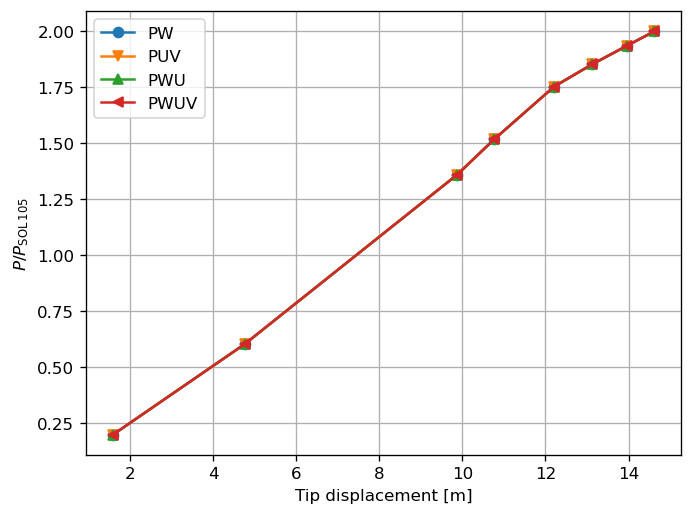

In [9]:
# Define error functions
error_functions = ['PW', 'PUV', 'PWU', 'PWUV']

nlparm_id = next(iter(ucrm9_bdf_input.nlparms))  # retrieve id of NLPARM card
_, ax = plt.subplots()  # create figure with one subplot

# Run analysis for each set of error functions and plot load-displacement diagram
for count, fun in enumerate(error_functions):
    ucrm9_bdf_input.nlparms[nlparm_id].conv = fun
    input_filename = 'nonlinear_analysis_error_function_' + fun
    compare_load_displacement_diagrams(ucrm9_bdf_input, input_filename, ax, markers[count], f'{fun}', run_flag=False)

# Set plot appearance
plt.xlabel('Tip displacement [m]')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

In [10]:
ucrm9_bdf_input.nlparms[nlparm_id].conv = 'PW'

Nastran job nonlinear_analysis_load_tolerance_1e-01.bdf completed
Wall time: 900.0 s


Nastran job nonlinear_analysis_load_tolerance_1e-02.bdf completed
Wall time: 375.0 s


Nastran job nonlinear_analysis_load_tolerance_1e-03.bdf completed
Wall time: 446.0 s


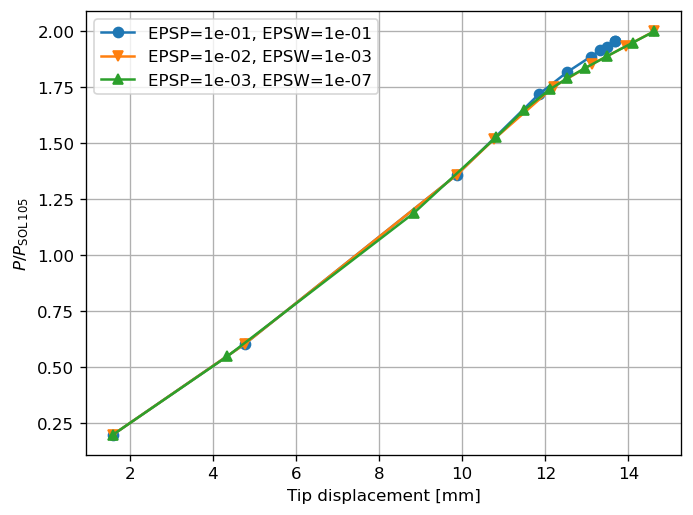

In [11]:
# Define error tolerances
load_tolerances = [1e-1, 1e-2, 1e-3]
work_tolerances = [1e-1, 1e-3, 1e-7]

# Create figure, run analysis for each couple of convergence tolerances and plot load-displacement diagram
_, ax = plt.subplots()
for count, epsp in enumerate(load_tolerances):
    epsw = work_tolerances[count]
    ucrm9_bdf_input.nlparms[nlparm_id].eps_p = epsp
    ucrm9_bdf_input.nlparms[nlparm_id].eps_w = epsw
    input_filename = f'nonlinear_analysis_load_tolerance_{epsp:.0e}'
    compare_load_displacement_diagrams(ucrm9_bdf_input, input_filename, ax, markers[count], f'EPSP={epsp:.0e}, EPSW={epsw:.0e}', run_flag=False)

# Set plot appearance
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

1. Aero load, $EPSP=10^{-1}, EPSW=10^{-1}, \Delta\mu^1=0.1, DESITER=12, MAXALR=4$
2. No load, $EPSP=10^{-1}, EPSW=10^{-1}, \Delta\mu^1=0.01, DESITER=5, MAXALR=1.01$

In [12]:
ucrm9_bdf_input.nlparms[nlparm_id].eps_p = 1e-1
ucrm9_bdf_input.nlparms[nlparm_id].eps_w = 1e-1

In [13]:
# Change load of first subcase
load_scale_factor = 1.9
ucrm9_bdf_input.load_combinations[load_set_id][0].scale_factors[0] = sol_105_buckling_factor*load_scale_factor

# Define load set with no applied force
zero_load_set_id = load_set_id+1
ucrm9_bdf_input.add_load(zero_load_set_id, scale=1., scale_factors=[0.], load_ids=[force_set_id])

# Create second subcase
subcase_id = 2
pynastran_utils.create_static_load_subcase(bdf_object=ucrm9_bdf_input, subcase_id=subcase_id, load_set_id=zero_load_set_id)
pynastran_utils.set_up_arc_length_method(bdf_object=ucrm9_bdf_input, nlparm_id=subcase_id, eps_p=1e-1, eps_w=1e-1, ninc=100, desiter=5, minalr=1e-2, maxalr=1.01, maxinc=250, subcase_id=subcase_id)

In [14]:
input_filename = f'bifurcation_verification_{load_scale_factor:.1f}Psol105_epsp1e-1'.replace('.','_')
no_eigenvalues = 6
op2_output_1_9Psol105_epsp1em1 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=ucrm9_bdf_input.__deepcopy__({}), method_set_id=zero_load_set_id+1, no_eigenvalues=no_eigenvalues, analysis_directory_path=analysis_directory_path, input_name=input_filename, run_flag=False)

Nastran job bifurcation_verification_1_9Psol105_epsp1e-1.bdf completed
Wall time: 2593.0 s


CORD2R         1              0.      0.      0.     -1.      0.      0.
              0.      0.      1.

CORD2R         2              0.      0.      0.     -1.      0.      0.
              0.      0.      1.

CORD2R         3              0.      0.      0.     -1.      0.      0.
              0.      0.      1.

CORD2R         4              0.      0.      0.     -1.      0.      0.
              0.      0.      1.

CORD2R         5              0.      0.      0.     -1.      0.      0.
              0.      0.      1.

CORD2R         6              0.      0.      0.     -1.      0.      0.
              0.      0.      1.

CORD2R         7              0.      0.      0.     -1.      0.      0.
              0.      0.      1.

CORD2R         8              0.      0.      0.     -1.      0.      0.
              0.      0.      1.

CORD2R         9              0.      0.      0.     -1.      0.      0.
              0.      0.      1.

CORD2R        10              0.     

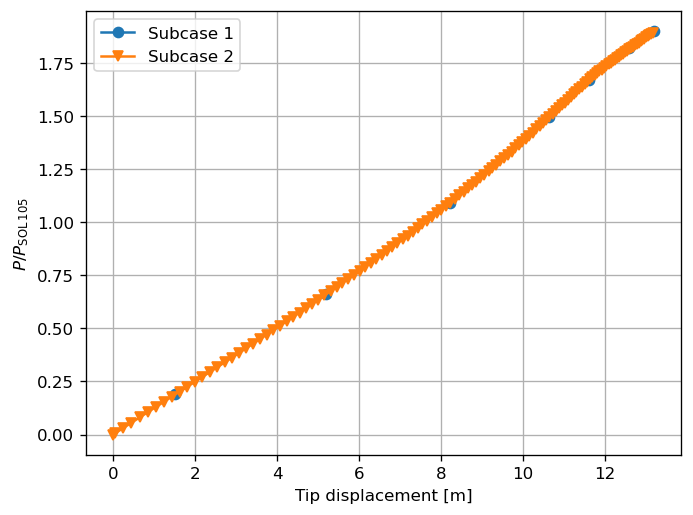

In [15]:
def plot_two_subcases_load_displacement_diagram(disp, steps):
    _, load_displacement_ax = plt.subplots()
    # First subcase
    load_displacement_ax.plot(disp[1][:, displacement_component_index], steps[1]*load_scale_factor, marker=markers[0], label=f'Subcase 1')
    # Second subcase
    load_displacement_ax.plot(disp[2][:, displacement_component_index], (steps[1][-1] - steps[2] + 1)*load_scale_factor, marker=markers[1], label=f'Subcase 2')
    # Set plot appearance
    load_displacement_ax.legend()
    plt.xlabel('Tip displacement [m]')
    plt.ylabel('$P/P_\mathrm{SOL\/105}$')
    plt.grid()
    plt.show()

load_steps_1_9Psol105_epsp1em1, _, tip_displacements_1_9Psol105_epsp1em1 = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output_1_9Psol105_epsp1em1, displacement_node_id=tip_node_id)
plot_two_subcases_load_displacement_diagram(tip_displacements_1_9Psol105_epsp1em1, load_steps_1_9Psol105_epsp1em1)

In [16]:
# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
#
# def plot_tangent_stiffness_matrix_eigenvalues(directory_path, filename, steps):
#     # Read eigenvalues
#     f06_path = os.path.join(directory_path, filename + '.f06')  # path to .f06 file
#     eigvals = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)
#     # Create figure with 2 subplots
#     _, eigvals_axs = plt.subplots(nrows=1, ncols=2, sharey='all')
#     iterations_count = 1
#     # Divide lowest eigenvalues by subcase
#     eigenvalues_count = 0
#     eigenvalues_by_subcase = {}
#     for subcase in steps:
#         no_load_steps = len(steps[subcase])
#         eigenvalues_by_subcase[subcase] = eigvals[:, eigenvalues_count:eigenvalues_count + no_load_steps]
#         eigenvalues_count += no_load_steps
#         # Plot eigenvalues vs iteration number
#         eigvals_axs[0].plot(np.arange(iterations_count, eigenvalues_by_subcase[subcase].shape[1] + iterations_count), eigenvalues_by_subcase[subcase].T, markers[subcase - 1], color=colors[subcase - 1], label=f'Subcase {subcase:d}')
#         iterations_count += eigenvalues_by_subcase[subcase].shape[1]
#         # Plot eigenvalues vs applied load
#         eigvals_axs[1].plot(steps[subcase]*load_scale_factor, eigenvalues_by_subcase[subcase].T, markers[subcase - 1], color=colors[subcase - 1])
#     # Set plot appearance
#     # axs[0].legend()
#     eigvals_axs[0].set_xlabel('Iteration')
#     eigvals_axs[0].set_ylabel('$\mathbf{K_T}$ eigenvalues')
#     eigvals_axs[0].grid(visible=True)
#     eigvals_axs[1].set_xlabel('$P/P_\mathrm{SOL\/105}$')
#     eigvals_axs[1].grid(visible=True)
#     plt.show()
#
# plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_filename, load_steps_1_9Psol105_epsp1em1)

1. Aero load, $EPSP=10^{-3}, EPSW=10^{-7}, \Delta\mu^1=0.1, DESITER=12, MAXALR=4$
2. No load, $EPSP=10^{-3}, EPSW=10^{-7}, \Delta\mu^1=0.01, DESITER=5, MAXALR=1.01$

In [17]:
for subcase_id in range(1, 3):
    ucrm9_bdf_input.nlparms[subcase_id].eps_p = 1e-3
    ucrm9_bdf_input.nlparms[subcase_id].eps_w = 1e-7

In [18]:
input_filename = f'bifurcation_verification_{load_scale_factor:.1f}Psol105_epsp1e-3'.replace('.','_')
op2_output_1_9Psol105_epsp1em3 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=ucrm9_bdf_input.__deepcopy__({}), method_set_id=zero_load_set_id+1, no_eigenvalues=no_eigenvalues, analysis_directory_path=analysis_directory_path, input_name=input_filename, run_flag=True)

Nastran job bifurcation_verification_1_9Psol105_epsp1e-3.bdf completed
Wall time: 1584.0 s


CORD2R         1              0.      0.      0.     -1.      0.      0.
              0.      0.      1.

CORD2R         2              0.      0.      0.     -1.      0.      0.
              0.      0.      1.

CORD2R         3              0.      0.      0.     -1.      0.      0.
              0.      0.      1.

CORD2R         4              0.      0.      0.     -1.      0.      0.
              0.      0.      1.

CORD2R         5              0.      0.      0.     -1.      0.      0.
              0.      0.      1.

CORD2R         6              0.      0.      0.     -1.      0.      0.
              0.      0.      1.

CORD2R         7              0.      0.      0.     -1.      0.      0.
              0.      0.      1.

CORD2R         8              0.      0.      0.     -1.      0.      0.
              0.      0.      1.

CORD2R         9              0.      0.      0.     -1.      0.      0.
              0.      0.      1.

CORD2R        10              0.     

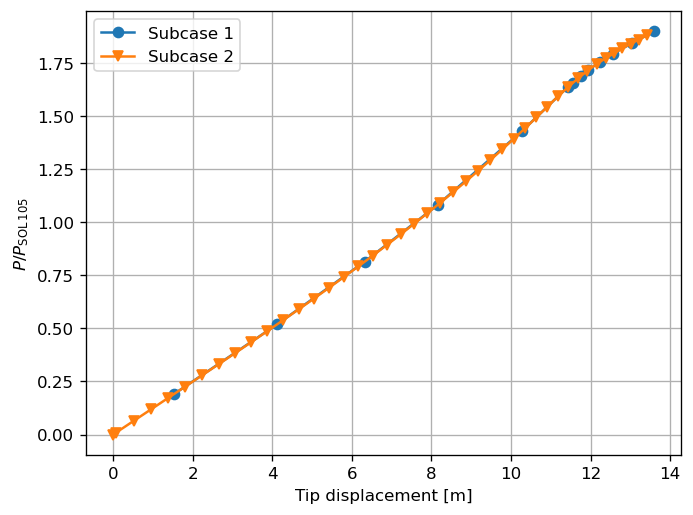

In [19]:
load_steps_1_9Psol105_epsp1em3, _, tip_displacements_1_9Psol105_epsp1em3 = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output_1_9Psol105_epsp1em3, displacement_node_id=tip_node_id)
plot_two_subcases_load_displacement_diagram(tip_displacements_1_9Psol105_epsp1em3, load_steps_1_9Psol105_epsp1em3)